In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import find_peaks

In [3]:
def zscore_2d(matrix):
    matrix_mean = matrix.mean(1, keepdims=True)
    matrix_std = matrix.std(1, keepdims=True)
    return (matrix - matrix_mean) / matrix_std

In [4]:
def get_freq(sampling_rate, level):
    freqs = []
    freq_top = sampling_rate * 0.5
    for i in range(1, level+1):
        start, end = freq_top * 0.5, freq_top
        freqs.append((start, end))
        freq_top = start
    freqs.append((0, freq_top))
    return freqs[::-1]

In [5]:
def load_RealData():
    traindata_path = '../../Data/RealData/all_back_train.npy'
    testdata_path = '../../Data/RealData/all_back_test.npy'

    train_data, test_data = np.load(traindata_path), np.load(testdata_path)
    signals_train, labels_train = train_data[:, :1000], train_data[:, 1000:]
    signals_test, labels_test = test_data[:, :1000], test_data[:, 1000:]

    print(signals_train.shape, labels_test.shape)

    return labels_train, labels_test, zscore_2d(signals_train), zscore_2d(signals_test)

In [6]:
def wavelet_denoise_select(signals, level, wavelet, sampling_rate, show=False):
    filtered_signals = []
    for signal in signals:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dep_freqs = get_freq(sampling_rate, level)

        coeffs_filtered = [np.zeros_like(coeffs[0])] + coeffs[1:5] + [np.zeros_like(c) for c in coeffs[5:]]
        reconstructed_signal = pywt.waverec(coeffs_filtered, wavelet)
        if show:
            print(dep_freqs[1:5])
            plt.figure(figsize=(12, 5))
            plt.plot(signal, label='Noisy Signal')
            plt.plot(reconstructed_signal, label='Filtered Signal')
            plt.legend()
            plt.show()
            break

        filtered_signals.append(reconstructed_signal)
        # break
    return np.array(filtered_signals)

In [7]:
def check_uncertain(signal, window, threshold_uncertain=0.2):
    end = len(signal)
    pieces_indexes = [(start, min(start + window, end)) for start in range(0, end, window)]
    pieced_signals = [signal[begin: over] for begin, over in pieces_indexes]

    def cal_energy(piece):
        return np.sum(np.square(piece))

    pieced_energy = [cal_energy(pieced_signal) for pieced_signal in pieced_signals]

    delta_pieced_energy = np.abs(np.diff(pieced_energy)) / pieced_energy[:-1]
    # delta_pieced_energy = np.array(pieced_energy[1:]) / pieced_energy[:-1]

    if np.sum(delta_pieced_energy <= threshold_uncertain) == len(delta_pieced_energy):
        # 全部符合标准，说明并没有不确定性
        uncertain = 0
    else:
        uncertain = 1

    return uncertain

# for idx in range(0, 300):
#     signal = filtered_signals[idx]
#     delta_energy = check_uncertain(signal, 200)
#
#     zero_crossings = np.where(np.diff(np.sign(signal)))[0]
#     zero_crossings_rate = len(zero_crossings) / (len(signal)-1)
#
#     # print(np.sum(delta_energy <= 0.2))
#     if (np.sum(delta_energy <= 0.2) == len(delta_energy)) and zero_crossings_rate < 0.13:
#         print(delta_energy)
#         print(zero_crossings_rate)
#         plt.figure()
#         plt.plot(filtered_signals[idx])
#         plt.show()

def zcr_and_status(signals, threshold=0.13):
    zcrs, status = [], []

    for cnt, signal in enumerate(signals):
        zero_crossings = np.where(np.diff(np.sign(signal)))[0]
        zero_crossings_rate = len(zero_crossings) / (len(signal)-1)
        zcrs.append(zero_crossings_rate)

        # 确定是否是uncertain的状态
        uncertain_bool = check_uncertain(signal, window=200)
        if uncertain_bool:
            status.append(-1)
        else:
            if zero_crossings_rate > threshold:
                status.append(0)
            else:
                status.append(1)

    return np.array(zcrs), np.array(status)

In [8]:
def re_status(signals, initial_statuses):
    """I don't need to implement it now."""
    return initial_statuses

def get_good_signals(signals, statuses, zcrs):
    good_signals_idx = []
    for cnt, (status, zcr) in enumerate(zip(statuses, zcrs)):
        if status == 1 and zcr < 0.125:
            good_signals_idx.append(cnt)
    # print(good_signals_idx)
    return signals[good_signals_idx], np.array(good_signals_idx)

In [9]:
# acf
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    acf = np.correlate(signal - mean, signal - mean, mode='full') / (np.var(signal) * n)
    return acf[n-1:]

def get_acfs(envelopes):
    acfs = []
    for env in envelopes:
        acf = autocorrelation(env)
        acfs.append(acf)
    return np.array(acfs)

In [10]:
def segmentation_nk2(signals, envelopes, labels, alpha, resample_rate):

    show = False
    all_pieces = []
    for cnt in range(len(signals)):

        envelope = envelopes[cnt]
        hr = labels[cnt, 2]
        signal = signals[cnt]
        peaks_temp, _ = find_peaks(envelope, height=np.max(envelope) * 0.15, distance=(int(5500*resample_rate) // hr))
        peaks_dis_mean = np.int(np.mean(np.diff(peaks_temp)))

        peaks, _ = find_peaks(envelope, height=np.max(envelope) * alpha, distance=(int(5000*resample_rate) // hr))

        if show:
            plt.figure(figsize=(12, 3))
            plt.plot(envelope)
            plt.plot(signal)
            plt.scatter(peaks ,envelope[peaks])
            plt.show()

        # epoch_start, epoch_end = int(0.45 * peaks_dis_mean), int(0.5 * peaks_dis_mean)
        epoch_start, epoch_end = int(0.65 * peaks_dis_mean), int(0.65 * peaks_dis_mean)

        pieces = []
        # print(len(peaks))
        # plt.figure(figsize=(12, 5))
        for i in range(len(peaks)):
            if peaks[i] - epoch_start < 0:
                continue
            if peaks[i] + epoch_end > int(1000*resample_rate):
                break

            start = peaks[i] - epoch_start
            end = peaks[i] + epoch_end
            # print(end-start, start, end)
            piece = signal[start: end]
            # print(len(piece))
            pieces.append(piece)
            # plt.plot(piece)
        # plt.show()
        all_pieces.append(pieces)

        if show:
            plt.figure(figsize=(12, 3))
            for line, piece in enumerate(pieces):
                plt.plot(piece, label=str(line))
            plt.legend()
            plt.show()
    return all_pieces

In [11]:
# # energy
def cal_energy(signals, window=32):
    show = False
    energies = []
    for cnt in range(len(signals)):
        signal = signals[cnt]

        signal_padded = np.pad(signal, [window//2, window//2], 'constant', constant_values=(0, 0))

        squared_signal = np.square(signal_padded)

        start = 0
        end = 0
        signal_energy = []
        for i in range(len(signal_padded)-window):
            start = i
            end = i + window
            signal_energy.append(np.sum(squared_signal[start:end]) / window)

        energies.append(np.array(signal_energy))
        if show:
            plt.figure(figsize=(12, 3))
            plt.plot(signal)
            plt.plot(signal_energy)
            plt.show()
    return energies

In [12]:
def find_last_zero_position(arr):
    zero_indices = np.where(arr == 0)[0]

    for zero_pos in zero_indices:
        if zero_pos <= 3:
            continue
        if arr[zero_pos-3] == 0 and arr[zero_pos-2] == 0 and arr[zero_pos-1] == 0 and arr[zero_pos+1] != 0:
            return zero_pos
    if len(zero_indices) > 0:
        return zero_indices[-1]
    else:
        return -1

def re_align(all_pieces):
    realigned_all_pieces = []
    for cnt, pieces in enumerate(all_pieces):
        padded_pieces = []
        for piece in pieces:
            padded_pieces.append(np.pad(piece, (35, 35), 'constant'))

        padded_pieces = np.array(padded_pieces)

        for i in range(len(padded_pieces)):
            time_series2 = padded_pieces[i]
            ccf_results = 0

            for j in range(len(padded_pieces)):
                if i == j:
                    continue
                time_series1 = padded_pieces[j]
                ccf_result = np.correlate(time_series1 - np.mean(time_series1), time_series2 - np.mean(time_series2), mode='full') / (np.std(time_series1) * np.std(time_series2) * len(time_series1))
                ccf_results += ccf_result

            lags = np.arange(-len(time_series1) + 1, len(time_series2))
            max_correlation_index = np.argmax(ccf_results)
            optimal_lag = lags[max_correlation_index]

            if optimal_lag > 30:
                optimal_lag = 30
            elif optimal_lag < -30:
                optimal_lag = -30
            new_time_series2 = np.roll(time_series2, optimal_lag)
            padded_pieces[i] = new_time_series2


        zero_start_max, zero_end_max = 0, 0
        for piece in padded_pieces:
            zero_start = find_last_zero_position(piece)
            zero_end = find_last_zero_position(piece[::-1])

            zero_start_max = max(zero_start, zero_start_max)
            zero_end_max = max(zero_end, zero_end_max)
        realigned_all_pieces.append(np.array(padded_pieces)[:, zero_start_max:-zero_end_max])

    return realigned_all_pieces

In [15]:
from scipy.signal import resample_poly

labels_train, labels_test, signals_train, signals_test = load_RealData()
wavelet = 'db12'
level = 6
sampling_rate = 100

filtered_signals = wavelet_denoise_select(signals_train, level, wavelet, sampling_rate)

print(filtered_signals.shape)
zcrs, statuses = zcr_and_status(filtered_signals)

final_statuses = re_status(filtered_signals, statuses)
good_signals, good_signals_index = get_good_signals(filtered_signals, final_statuses, zcrs)
print(good_signals.shape)
good_labels = labels_train[good_signals_index]
print(good_labels.shape)

def resample_signals(signals, resample_rate):
    resampled_signals = [resample_poly(signal, int(1000*resample_rate), 1000) for signal in signals]
    return np.array(resampled_signals)

resample_rate = 1.5
good_signals = resample_signals(good_signals, 1.5)


(4672, 1000) (1655, 6)
(4672, 1000)
(270, 1000)
(270, 6)


In [49]:
from scipy.signal import savgol_filter
sg_good_signals_8 = [savgol_filter(signal, 8, 2) for signal in good_signals]
sg_good_signals_16 = [savgol_filter(signal, 16, 2) for signal in good_signals]
sg_good_signals_32 = [savgol_filter(signal, 32, 2) for signal in good_signals]
sg_good_signals_64 = [savgol_filter(signal, 64, 2) for signal in good_signals]
sg_good_signals_128 = [savgol_filter(signal, 128, 2) for signal in good_signals]


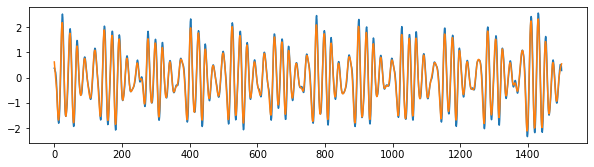

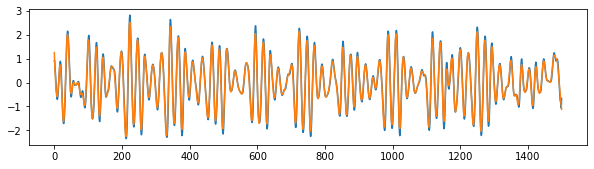

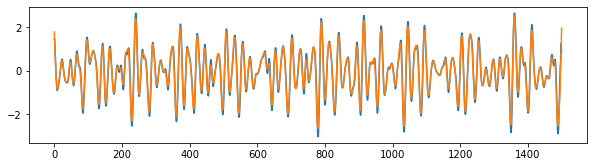

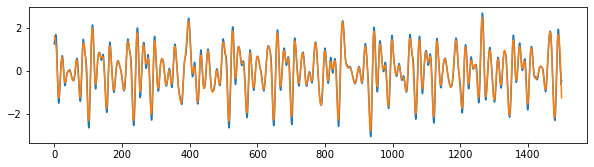

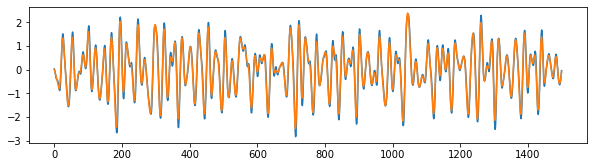

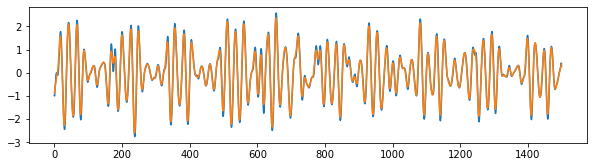

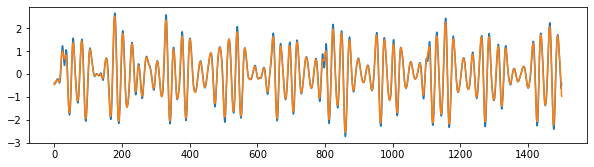

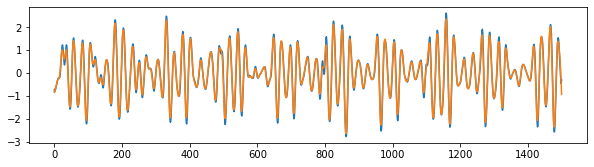

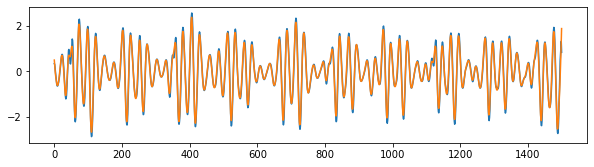

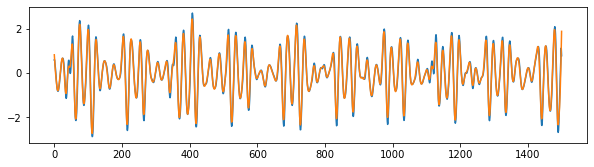

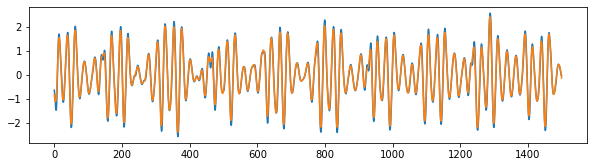

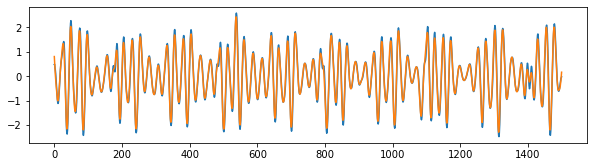

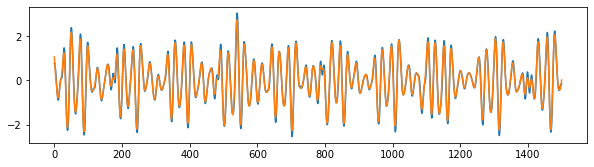

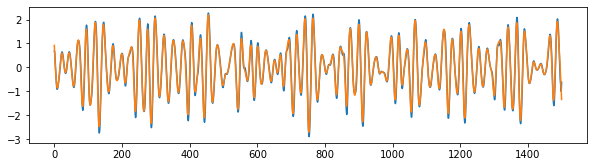

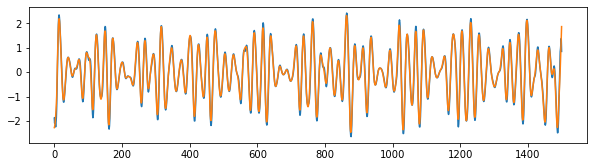

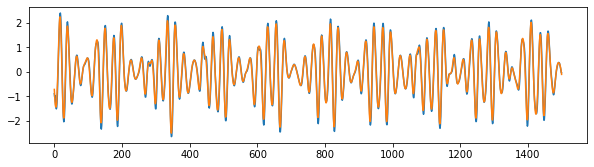

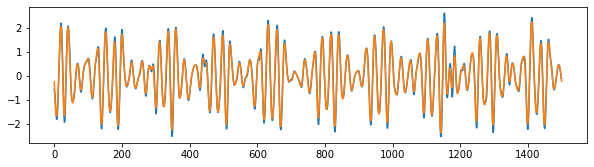

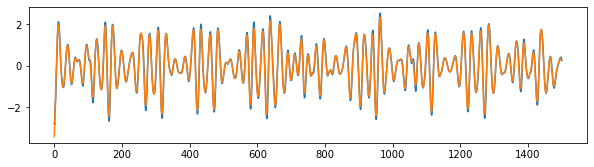

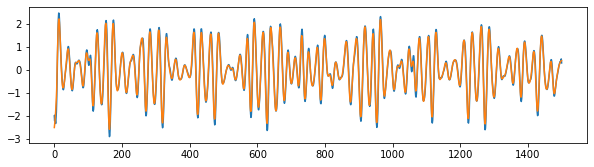

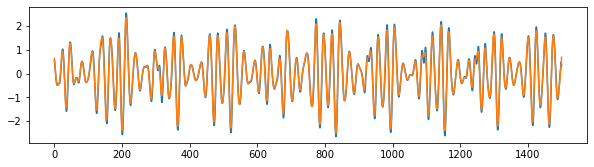

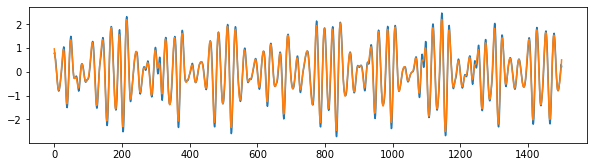

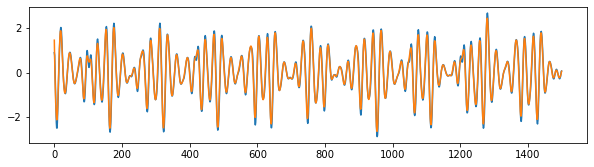

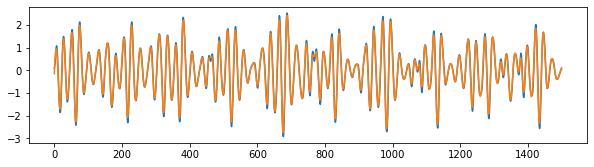

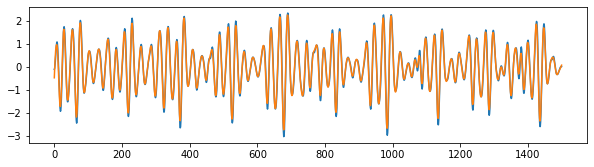

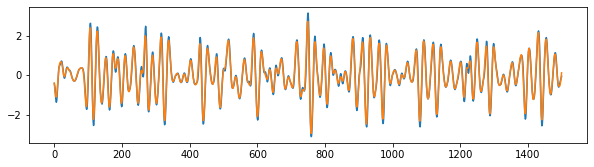

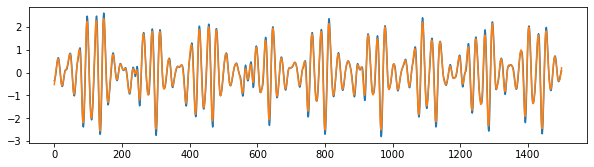

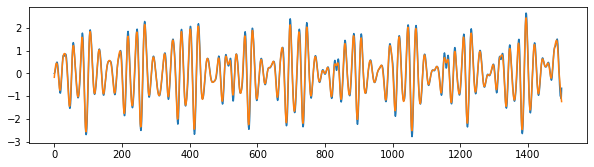

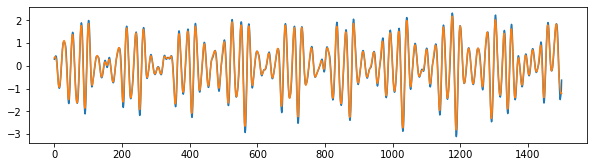

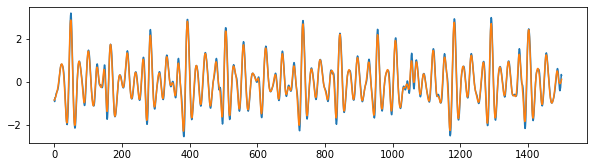

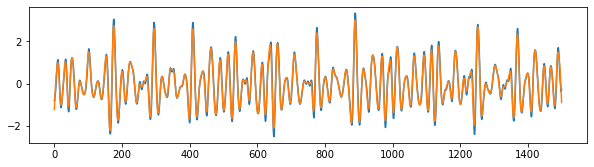

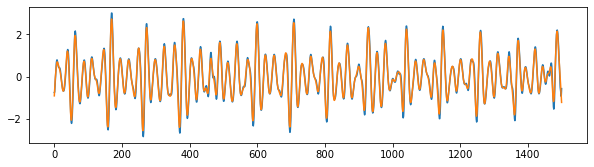

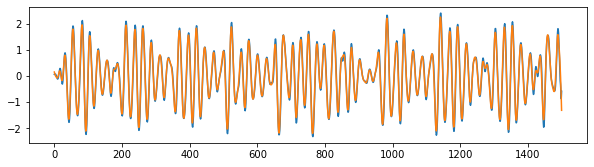

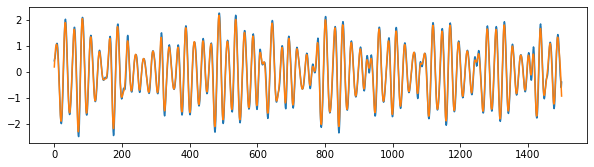

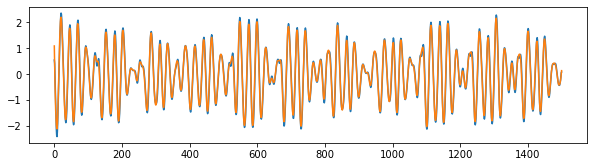

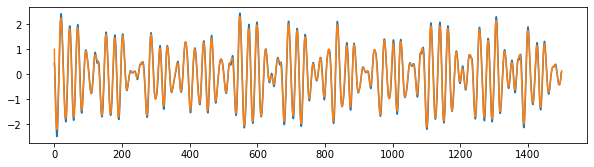

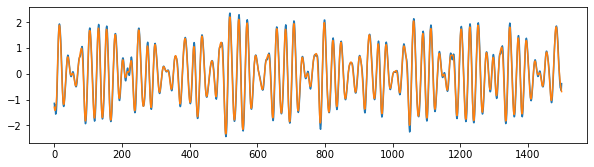

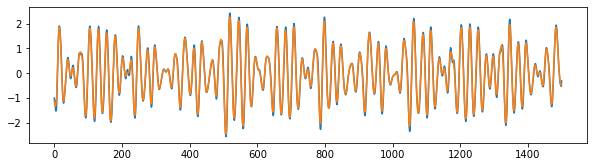

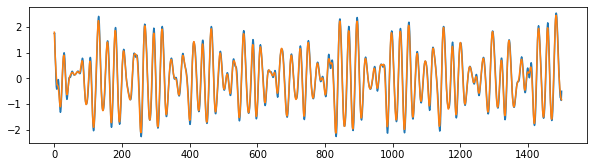

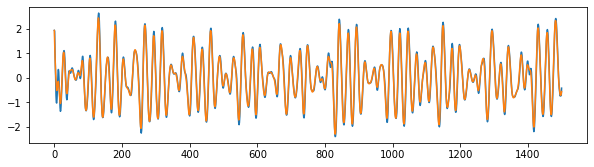

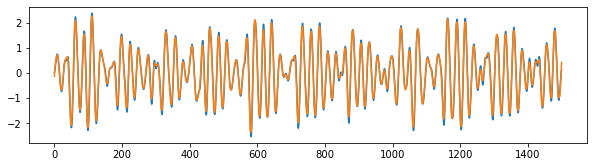

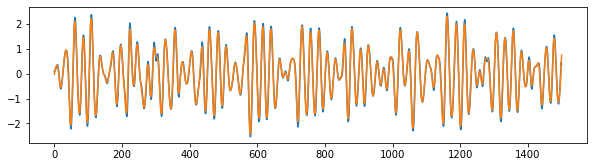

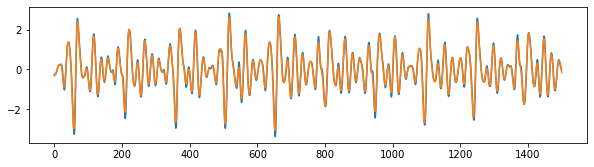

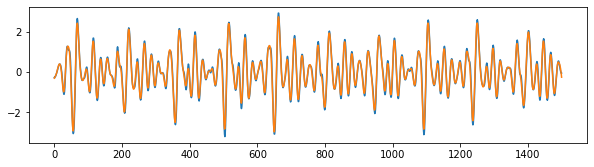

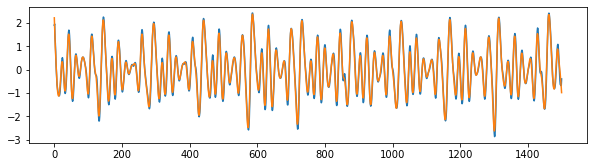

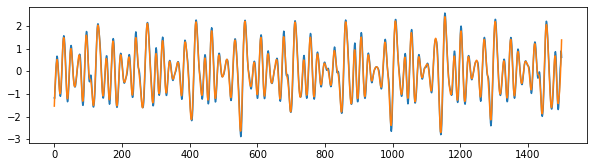

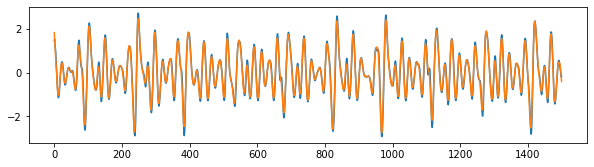

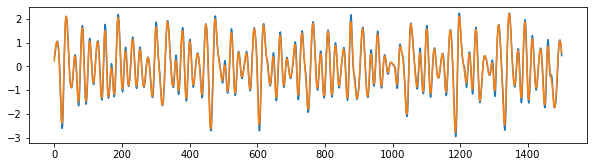

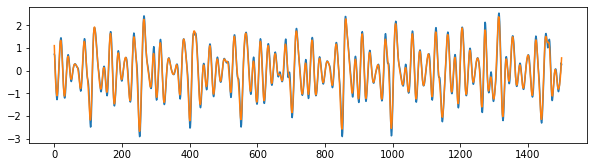

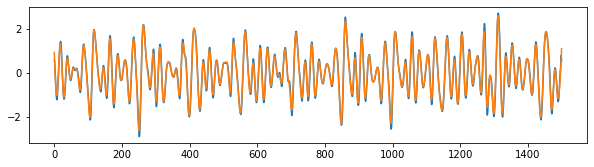

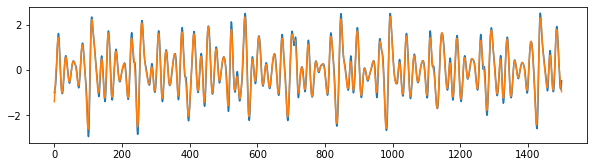

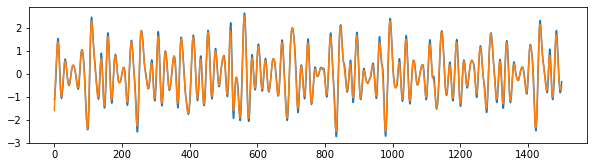

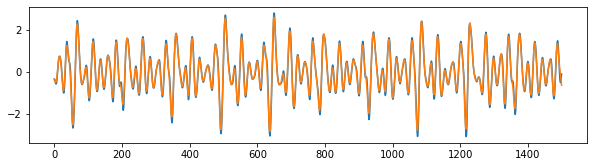

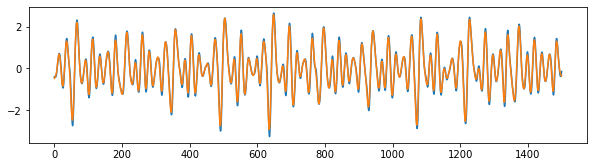

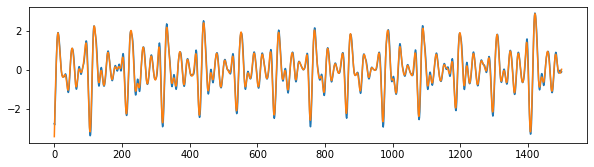

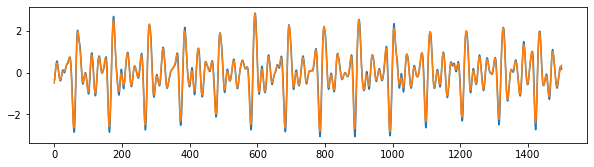

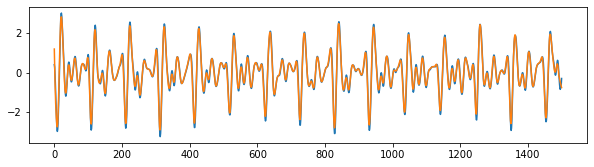

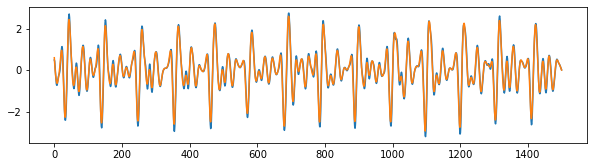

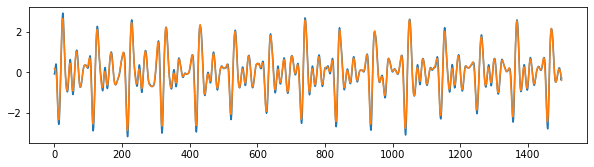

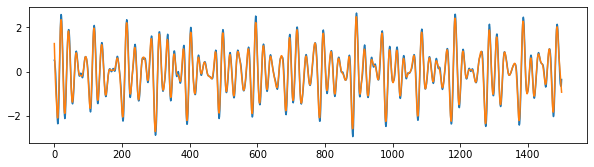

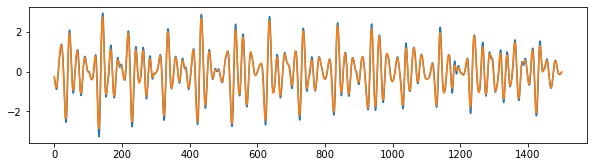

In [79]:
for idx in range(10, 70):

    plt.figure(figsize=(10, 2.5))
    # plt.plot(sg_good_signals_8[idx])
    plt.plot(good_signals[idx])

    plt.plot(sg_good_signals_16[idx])
    # plt.plot(sg_good_signals_32[idx])
    # plt.plot(sg_good_signals_64[idx])
    # plt.plot(sg_good_signals_128[idx])

    # plt.plot(good_signals[idx] - sg_good_signals_8[idx])
    plt.show()